In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import respy as rp
import numpy as np

# Maximum likelihood estimation

## Simulation

We first simulate a sample from one of the example models.

In [105]:
params_base, options_base, df = rp.get_example_model("robinson", with_data=True)

Let's look at the parameterization of the model and the specified options.

In [91]:
print(" Parametrization")
print(params_base)
print("\n Options")
options_base

 Parametrization
                                     value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

 Options


{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

We can study the resulting choice patterns.

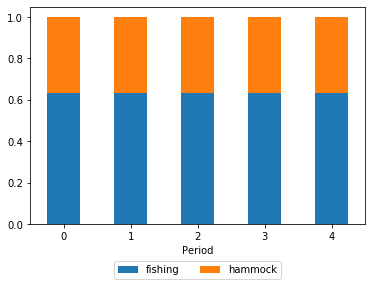

In [92]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)


plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()


## Likelihood function

We can now start exploring the likelihood function. We will first trace out the profile likelihood over reasonable parameter values.

In [106]:
params_base["lower"] = [0.9, 0.00, -0.20, 1.00, 0.0050, 0.001, -0.2]
params_base["upper"] = [1.0, 0.10,  0.00, 1.10, 0.0150, 0.030, +0.2]

### Profile likelihood

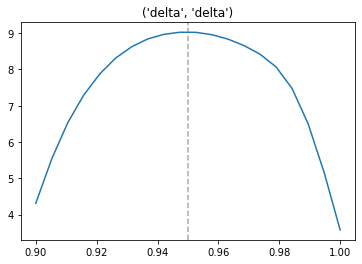

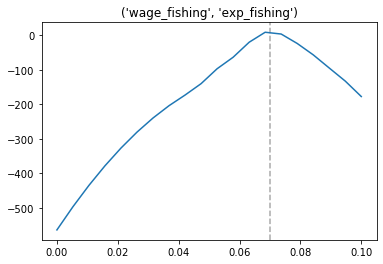

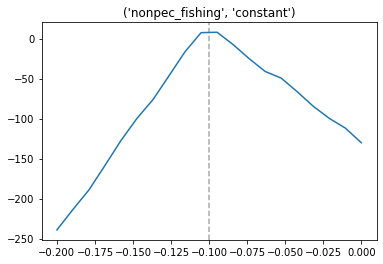

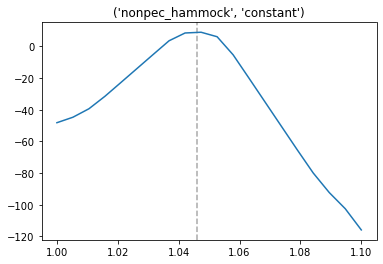

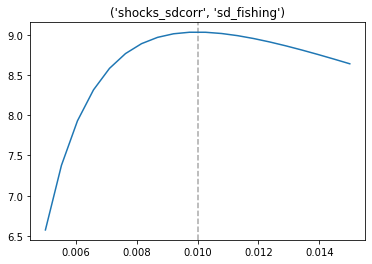

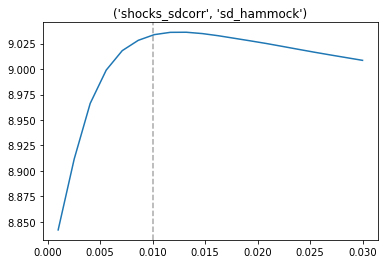

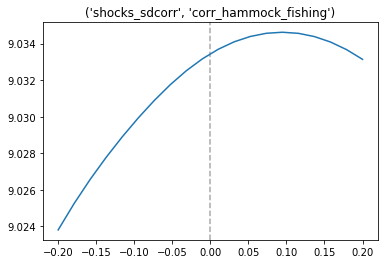

In [94]:
crit_func = rp.get_crit_func(params_base, options_base, df)

for index in params_base.index:
    upper, lower = params_base.loc[index][["upper", "lower"]]

    grid = np.linspace(lower, upper, 20)
    
    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))
    
    fig, ax = plt.subplots()

    ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--", label="Baseline")
    
    ax.plot(grid, fvals)
    ax.set_title(index)
    plt.show()

### Smoothing parameter

There are many numerical tuning parameters involved in the construction of the likelihood function (e.g. numerical integration, smoothing parameter). We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$.

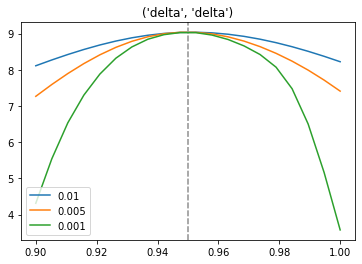

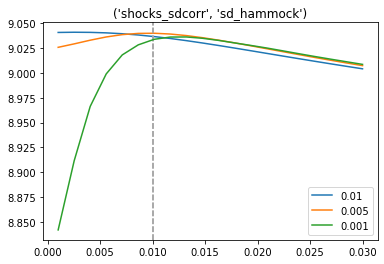

In [95]:
for index in [("delta", "delta"), ("shocks_sdcorr", "sd_hammock")]:
    fig, ax = plt.subplots()

    for tau in [0.01, 0.005, 0.001]:

        options = options_base.copy()
        options["estimation_tau"] = tau

        crit_func = rp.get_crit_func(params_base, options, df)

        upper, lower = params_base.loc[index][["upper", "lower"]]

        grid = np.linspace(lower, upper, 20)

        fvals = list()
        for value in grid:
            params = params_base.copy()
            params.loc[index, "value"] = value
            fvals.append(crit_func(params))

        ax.axvline(params_base.loc[index, "value"], color="#A9A9A9", linestyle="--")

        ax.plot(grid, fvals, label=f"{tau}")
        ax.set_title(index)
        ax.legend()

    plt.show()

## Estimation

In [107]:
from estimagic.optimization.optimize import maximize

In [117]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    {"loc": "delta", "type": "fixed", "value": 0.95}
]

params_start = params_base.copy()
params_start["group"] = params_base.index.get_level_values('category')

crit_func = rp.get_crit_func(params_base, options_base, df)

print(f" Value of criterion function at truth: {crit_func(params_base)}")

 Value of criterion function at truth: 9.033443270309705


In [109]:
params_start.loc[("wage_fishing", "exp_fishing"), "value"] = 0.04
results, params_rslt = maximize(
        crit_func, params_start, 
        "nlopt_bobyqa", 
        algo_options={"maxeval": 1}, 
        constraints=constr, 
        dashboard=False
    )

/home/peisenha/.local/share/anaconda3/envs/respy/lib/python3.7/site-packages/estimagic/optimization/reparametrize.py:190: UserWarning: Bounds are ignored for covariance parameters.
  "Bounds are ignored for covariance parameters.", UserWarning


Bokeh app running at: http://localhost:52591/


In [121]:
fvals = list()
for _ in range(2):
    
    np.random.seed()
    
    # We create some random starting values.
    for index in params_start.index:
        upper, lower = params_base.loc[index][["upper", "lower"]]
        params_start.loc[index, "value"] = np.random.uniform(lower, upper)

    results, params_rslt = maximize(
                crit_func, params_start, 
                "nlopt_bobyqa", 
                algo_options={"maxeval": 100}, 
                constraints=constr, 
                dashboard=False
            )
    fvals.append(results["fun"])
    

                                        value  lower  upper           group
category       name                                                        
delta          delta                 0.900358  0.900  1.000           delta
wage_fishing   exp_fishing           0.050053  0.000  0.100    wage_fishing
nonpec_fishing constant             -0.144651 -0.200  0.000  nonpec_fishing
nonpec_hammock constant              1.055708  1.000  1.100  nonpec_hammock
shocks_sdcorr  sd_fishing            0.011364  0.005  0.015   shocks_sdcorr
               sd_hammock            0.024683  0.001  0.030   shocks_sdcorr
               corr_hammock_fishing -0.100338 -0.200  0.200   shocks_sdcorr


/home/peisenha/.local/share/anaconda3/envs/respy/lib/python3.7/site-packages/estimagic/optimization/check_constraints.py:150: UserWarning: Parameter ('delta', 'delta') is fixed to 0.95 but value column is 0.9003579832287828
  p, fvalue, value
/home/peisenha/.local/share/anaconda3/envs/respy/lib/python3.7/site-packages/estimagic/optimization/reparametrize.py:190: UserWarning: Bounds are ignored for covariance parameters.
  "Bounds are ignored for covariance parameters.", UserWarning


                                        value  lower  upper           group
category       name                                                        
delta          delta                 0.996952  0.900  1.000           delta
wage_fishing   exp_fishing           0.073604  0.000  0.100    wage_fishing
nonpec_fishing constant             -0.037138 -0.200  0.000  nonpec_fishing
nonpec_hammock constant              1.033615  1.000  1.100  nonpec_hammock
shocks_sdcorr  sd_fishing            0.013235  0.005  0.015   shocks_sdcorr
               sd_hammock            0.012411  0.001  0.030   shocks_sdcorr
               corr_hammock_fishing -0.146192 -0.200  0.200   shocks_sdcorr


/home/peisenha/.local/share/anaconda3/envs/respy/lib/python3.7/site-packages/estimagic/optimization/check_constraints.py:150: UserWarning: Parameter ('delta', 'delta') is fixed to 0.95 but value column is 0.9969517557142678
  p, fvalue, value
/home/peisenha/.local/share/anaconda3/envs/respy/lib/python3.7/site-packages/estimagic/optimization/reparametrize.py:190: UserWarning: Bounds are ignored for covariance parameters.
  "Bounds are ignored for covariance parameters.", UserWarning
